In [47]:
import os
import json
import math
import numpy as np 
import pandas as pd


## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline 
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
from skimage.util import random_noise

## PyTorch
## Backprop Learning
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

## Hebbian Learning
!pip install nupic.torch-master.zip
from nupic.torch.modules import (
    KWinners2d, KWinners, SparseWeights, SparseWeights2d, Flatten,
    rezero_weights, update_boost_strength
)

C:\Users\piomi\AppData\Local\Temp\ipykernel_13644\1715768785.py:12: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


Defaulting to user installation because normal site-packages is not writeable

ERROR: Could not build wheels for nupic.torch, which is required to install pyproject.toml-based projects

[notice] A new release of pip available: 22.2.1 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip



Processing c:\mgr materialy + praca mgr\4 + 2 semestr\ssne\mp5\nupic.torch-master.zip
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
Failed to build nupic.torch


In [48]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


In [49]:
# Transformations applied on each image => only make them a tensor
class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                ])

# Loading the training dataset. We need to split it into a training and validation part
dataset = ImageFolder("trafic_32", transform=transform)

In [50]:
batch_size = 512
train_loader = data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=2)

In [134]:
# Sparsity parameters
SPARSITY = 0.66
SPARSITY_CNN = SPARSITY

# K-Winners parameters
PERCENT_ON = 0.66
BOOST_STRENGTH = 1.7
relu_flag = False

# Models
latent_dim = 256
img_size = 32 * 32 * 3

# W-GAN PARAMETERS
WEIGHT_CLIP = 0.01
disc_iter = 5

In [237]:
class Cond_Generator(nn.Module):
    def __init__(self, batch_size,latent_dim, hidden_dim, output_dim, num_of_classes,SPARSITY_CNN,BOOST_STRENGTH,PERCENT_ON,relu_flag):
        super(Cond_Generator, self).__init__()
        self.batch_size = batch_size
        self.latent_dim = latent_dim
        self.hidden_dim = hidden_dim
        self.output_dim = int(output_dim)
        self.num_of_classes = num_of_classes
        self.relu_flag= relu_flag
        self.SPARSITY_CNN = SPARSITY_CNN
        #
        # self.fc_1 = nn.Sequential(nn.Linear(self.latent_dim+self.num_of_classes, self.latent_dim+self.num_of_classes))
        #
        # # self.fc_2 = nn.Sequential(SparseWeights(nn.Linear(self.hidden_dim, self.hidden_dim), sparsity=SPARSITY),
        # # KWinners(n=self.hidden_dim, percent_on=PERCENT_ON, boost_strength=BOOST_STRENGTH,relu=self.relu_flag),)
        #
        # self.fc_2 = nn.Sequential(nn.Linear(self.latent_dim+self.num_of_classes, int(self.hidden_dim)))
        # self.LeakyReLU = nn.LeakyReLU(0.2)

        self.cntv_1 = nn.Sequential(
            nn.ConvTranspose2d(int(self.latent_dim+1), int(self.hidden_dim * 2), kernel_size=(3, 3), stride=(1, 1), padding=(0, 0), bias=False),
            KWinners2d(channels=int(self.hidden_dim*2), percent_on=PERCENT_ON, boost_strength=BOOST_STRENGTH,relu=self.relu_flag),
            nn.Dropout(0.2)
        )

        self.cntv_2 = nn.Sequential(
            SparseWeights2d(nn.ConvTranspose2d( int(self.hidden_dim*2), int(self.hidden_dim*2), kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False),sparsity=self.SPARSITY_CNN),
            nn.BatchNorm2d(int(self.hidden_dim*2)),
            KWinners2d(channels=int(self.hidden_dim*2), percent_on=PERCENT_ON, boost_strength=BOOST_STRENGTH,relu=self.relu_flag),
            nn.Dropout(0.2)
        )

        self.cntv_3 = nn.Sequential(
            SparseWeights2d(nn.ConvTranspose2d(int(self.hidden_dim*2), int(self.hidden_dim*2), kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False),sparsity=self.SPARSITY_CNN),
            nn.BatchNorm2d(int(self.hidden_dim*2)),
            KWinners2d(channels=int(self.hidden_dim*2), percent_on=PERCENT_ON, boost_strength=BOOST_STRENGTH,relu=self.relu_flag),
            nn.Dropout(0.2)
        )

        self.cntv_4 = nn.Sequential(
            SparseWeights2d(nn.ConvTranspose2d(int(self.hidden_dim*2), int(self.hidden_dim*2), kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False), sparsity=self.SPARSITY_CNN),
            nn.BatchNorm2d(int(self.hidden_dim*2)),
            KWinners2d(channels=int(self.hidden_dim*2), percent_on=PERCENT_ON, boost_strength=BOOST_STRENGTH,relu=self.relu_flag),
            nn.Dropout(0.2)
        )

        self.cntv_5 =  nn.Sequential(
            SparseWeights2d(nn.ConvTranspose2d(int(self.hidden_dim*2), int(self.hidden_dim*2), kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False), sparsity=self.SPARSITY_CNN),
            nn.BatchNorm2d(int(self.hidden_dim*2)),
            KWinners2d(channels=int(self.hidden_dim*2), percent_on=PERCENT_ON, boost_strength=BOOST_STRENGTH,relu=self.relu_flag),
            nn.Dropout(0.2)
        )

        self.cntv_6 = nn.Sequential(
            nn.ConvTranspose2d(int(self.hidden_dim*2), int(self.output_dim/32/32), kernel_size=(4,4), stride=(1,1), padding=(2,2), bias=False),
            nn.Dropout(0.2)
        )
        self.weights_init()
    def weights_init(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
            torch.nn.init.constant_(m.bias, val=0)

    def forward(self, x,y):
        #print("0x",x.size())
        #print("0y",y.size())
        #x = torch.reshape(x,(self.batch_size,self.latent_dim,1,1))
        #y = torch.reshape(y,(self.batch_size,1,1,1))
        #print("1y",y.size())
        x = torch.flatten(x, 1)
        #print("xflat",x.size()) # xflat torch.Size([64128])
        x = torch.cat([x,y], 1)
        #print("1x",x.size()) ## 1x torch.Size([128, 501, 1, 1])
        # x = self.LeakyReLU(self.fc_1(x))
        #print("2x",x.size()) #2x torch.Size([128, 501])
        # x = self.LeakyReLU(self.fc_2(x))
        #x = torch.reshape(x,(self.hidden_dim,self.latent_dim,1,1))
        #print("3x",x.size())
        x = x.view([-1,self.latent_dim+1,1,1])
        #print("xres",x.size())
        x = self.cntv_1(x)
        # print("2",x.size())
        x = self.cntv_2(x)
        # print("3",x.size())#
        x = self.cntv_3(x)
        # print("4",x.size())#
        x = self.cntv_4(x)
        #print("5",x.size())#
        x = self.cntv_5(x)
        #print("6",x.size())#
        x = self.cntv_6(x)
        #print("6",x.size())#
        x = x.view([-1, 3, 32, 32])
        return torch.tanh(x)

In [233]:
class Cond_Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_of_classes,batch_size,SPARSITY_CNN,BOOST_STRENGTH,PERCENT_ON,relu_flag):
        super(Cond_Discriminator, self).__init__()
        self.input_dim = int(input_dim/32/32)
        self.hidden_dim = hidden_dim
        self.num_of_classes = num_of_classes
        self.relu_flag= relu_flag
        self.batch_size = batch_size

        self.cnn_1 = nn.Sequential(
            nn.Conv2d(self.input_dim, self.hidden_dim, kernel_size=(3,3), stride=(2,2), padding=(1,1), bias=False),
            nn.LeakyReLU(0.2, inplace=True),
        )

        self.cnn_2 = nn.Sequential(
            nn.Conv2d(self.hidden_dim, self.hidden_dim*2, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
        nn.BatchNorm2d(self.hidden_dim * 2),
        KWinners2d(channels=int(self.hidden_dim * 2), percent_on=PERCENT_ON, boost_strength=BOOST_STRENGTH,relu=self.relu_flag),
        )

        self.cnn_3 = nn.Sequential(
            nn.Conv2d(self.hidden_dim*2, self.hidden_dim*4, kernel_size=(4,4), stride=(2,2), padding=(1,1), bias=False),
        nn.BatchNorm2d(self.hidden_dim * 4),
        KWinners2d(channels=int(self.hidden_dim * 4), percent_on=PERCENT_ON, boost_strength=BOOST_STRENGTH,relu=self.relu_flag),
        )

        self.cnn_4 = nn.Sequential(
            nn.Conv2d(self.hidden_dim * 4, 1, kernel_size=(4,4), stride=(1,1), padding=(0,0), bias=False)
        )

        # self.sparse_cnn_4 = nn.Sequential(
        #     nn.Conv2d(self.hidden_dim * 4, self.input_dim + self.num_of_classes, kernel_size=(4,4), stride=(1,1), padding=(0,0), bias=False)
        # )

        # self.fc_1 = nn.Linear(2560, int(self.hidden_dim))
        # self.fc_2 = nn.Linear(int(self.hidden_dim), int(self.hidden_dim))
        # self.fc_out  = nn.Linear(int(self.hidden_dim),self.batch_size)
        #
        # self.LeakyReLU = nn.LeakyReLU(0.2)
    #     self.weights_init()
    def weights_init(m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
        if isinstance(m, nn.BatchNorm2d):
            torch.nn.init.normal_(m.weight, mean=0.0, std=0.02)
            torch.nn.init.constant_(m.bias, val=0)
    def forward(self, x, y):
        #print("y",y.size())
        #print("x",x.size())

        #print("0",x.size())
        x = self.cnn_1(x)
        #print("1",x.size())
        x = self.cnn_2(x)
        x = self.cnn_3(x)
        #print("2",x.size())
        x = self.cnn_4(x)
        #print("3",x.size())# 3 torch.Size([512, 4, 1, 1])
        #print("y",y.size())# y torch.Size([512, 1])
        #y = torch.reshape(y,(self.batch_size,1,1,1))
        #print("yr",y.size())
        # x = torch.reshape(x,(512,4))
        #
        # #print("xf",x.size())
        # x = torch.cat([x,y], 1)
        # x = torch.flatten(x)
        #
        #
        # #print("4",x.size()) # 4 torch.Size([2560])
        # x = self.LeakyReLU(self.fc_1(x))
        # #print("5",x.size())
        # x = self.LeakyReLU(self.fc_2(x))
        # #print("6",x.size())
        # x = self.fc_out(x)
        #print("4",x.size())
        return torch.sigmoid(x)

In [238]:

cond_generator = Cond_Generator(batch_size=batch_size,latent_dim=latent_dim, hidden_dim=128, output_dim=img_size, num_of_classes=len(dataset.classes),SPARSITY_CNN=SPARSITY_CNN,BOOST_STRENGTH=BOOST_STRENGTH,PERCENT_ON=PERCENT_ON,relu_flag=relu_flag).to(device)
cond_discriminator = Cond_Discriminator( hidden_dim=32, input_dim=img_size, num_of_classes=len(dataset.classes),batch_size=batch_size,SPARSITY_CNN=SPARSITY_CNN,BOOST_STRENGTH=BOOST_STRENGTH,PERCENT_ON=PERCENT_ON,relu_flag=relu_flag).to(device)

# Optimizers
generator_optimizer = torch.optim.Adam(cond_generator.parameters(), lr=0.0001)
# generator_optimizer = torch.optim.RMSprop(cond_generator.parameters(), lr=0.00005)
generator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=generator_optimizer, gamma=0.99)
discriminator_optimizer = torch.optim.Adam(cond_discriminator.parameters(), lr=0.0001)
# discriminator_optimizer = torch.optim.RMSprop(cond_discriminator.parameters(), lr=0.00005)
discriminator_scheduler = optim.lr_scheduler.ExponentialLR(optimizer=discriminator_optimizer, gamma=0.99)

# loss
#criterion = nn.MSELoss()
criterion  = nn.BCELoss()
#criterion = nn.BCEWithLogitsLoss()

In [186]:
fixed_noise = torch.randn(32, latent_dim,device=device)
fixed_labels = torch.randint(len(dataset.classes),(32,),device=device)
fixed_labels = F.one_hot(fixed_labels, len(dataset.classes)).float()

## Trening

No. of Parametres - G :  2965760
No. of Trainable parametres - G :  2965760
No. of Parametres - D :  167136
No. of Trainable parametres - D :  167136
Epoch: 0, discrimiantor fake error: 0.233, discriminator real acc: 0.724


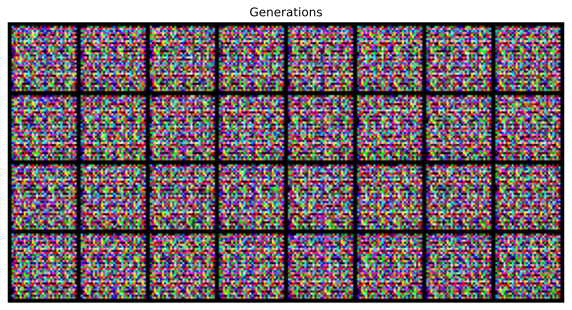

Epoch: 1, discrimiantor fake error: 0.0271, discriminator real acc: 0.879
Epoch: 2, discrimiantor fake error: 0.0182, discriminator real acc: 0.885
Epoch: 3, discrimiantor fake error: 0.00917, discriminator real acc: 0.892
Epoch: 4, discrimiantor fake error: 0.0122, discriminator real acc: 0.885
Epoch: 5, discrimiantor fake error: 0.00766, discriminator real acc: 0.892
Epoch: 6, discrimiantor fake error: 0.00903, discriminator real acc: 0.895
Epoch: 7, discrimiantor fake error: 0.015, discriminator real acc: 0.886
Epoch: 8, discrimiantor fake error: 0.0128, discriminator real acc: 0.888
Epoch: 9, discrimiantor fake error: 0.00726, discriminator real acc: 0.893
Epoch: 10, discrimiantor fake error: 0.00572, discriminator real acc: 0.896


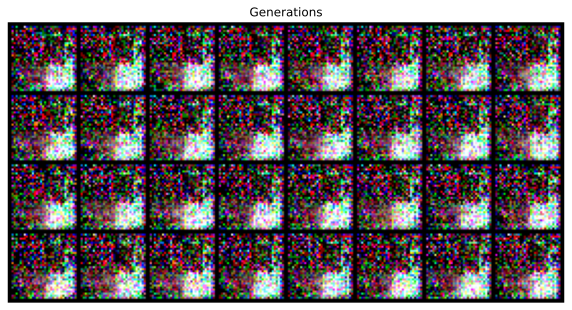

Epoch: 11, discrimiantor fake error: 0.00379, discriminator real acc: 0.896


KeyboardInterrupt: 

In [239]:
G_losses = []
D_losses = []

################# NO. PARAMS ####################
G_total_params = sum(p.numel() for p in cond_generator.parameters() if p.requires_grad)
print("No. of Parametres - G : ", G_total_params)
G_total_params = sum(p.numel() for p in cond_generator.parameters() if p.requires_grad)
print("No. of Trainable parametres - G : ", G_total_params)

D_total_params = sum(p.numel() for p in cond_discriminator.parameters() if p.requires_grad)
print("No. of Parametres - D : ", D_total_params)
D_total_params = sum(p.numel() for p in cond_discriminator.parameters() if p.requires_grad)
print("No. of Trainable parametres - D : ", D_total_params)
################# NO. PARAMS ####################

num_epochs = 40
for epoch in range(num_epochs):
    # For each batch in the dataloader
    discriminator_fake_acc = []
    discriminator_real_acc = []
    for i, data in enumerate(train_loader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator_optimizer.zero_grad()
        # Format batch
        real_images = data[0].to(device)
        b_size = real_images.size(0)
        #for _ in range(disc_iter):
        y = data[1]
        y = F.one_hot(y, num_classes=len(dataset.classes)).to(device).float()

        label = torch.full((b_size,),0.9, dtype=torch.float, device=device) # Setting labels for real images & preventing overconfidence
        # Forward pass real batch through D
        output = cond_discriminator(real_images, y).view(-1)
        # Calculate loss on all-real batch
        error_discriminator_real = criterion(output, label)
        #error_discriminator_real = torch.mean(output)
        # Calculate gradients for D in backward pass
        error_discriminator_real.backward()
        discriminator_real_acc.append(output.mean().item())

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dim,device=device)
        rand_y = torch.randint(len(dataset.classes),(b_size,),device=device)
        rand_y = F.one_hot(rand_y, len(dataset.classes)).float()
        # Generate fake image batch with Generator
        fake_images = cond_generator(noise, rand_y)
        label_fake = torch.full((b_size,),0.0, dtype=torch.float, device=device)
        # Classify all fake batch with Discriminator
        output = cond_discriminator(fake_images.detach(), rand_y).view(-1)
        # Calculate D's loss on the all-fake batch
        error_discriminator_fake = criterion(output, label_fake)
        #error_discriminator_fake = torch.mean(output)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        error_discriminator_fake.backward()
        discriminator_fake_acc.append(output.mean().item())
        # Compute error of D as sum over the fake and the real batches
        error_discriminator = error_discriminator_real + error_discriminator_fake
        # Update D
        #error_discriminator.backward()
        discriminator_optimizer.step()

        # for p in cond_discriminator.parameters():
        #         p.data.clamp_(-WEIGHT_CLIP, WEIGHT_CLIP)
        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
#         for _ in range(3):
        noise = torch.randn(b_size, latent_dim,device=device)
        rand_y = torch.randint(len(dataset.classes),(b_size,),device=device)
        rand_y = F.one_hot(rand_y, len(dataset.classes)).float()
        fake_images = cond_generator(noise, rand_y)
        generator_optimizer.zero_grad()
        label = torch.full((b_size,),1., dtype=torch.float, device=device)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = cond_discriminator(fake_images, rand_y).view(-1)
        # Calculate G's loss based on this output
        error_generator = criterion(output, label)
        #error_generator = torch.mean(output)
        # Calculate gradients for G
        error_generator.backward()
        D_G_z2 = output.mean().item()
        # Update G
        generator_optimizer.step()

        # Output training stats
        # Save Losses for plotting later
        G_losses.append(error_generator.item())
        D_losses.append(error_discriminator.item())


    print(f"Epoch: {epoch}, discrimiantor fake error: {np.mean(discriminator_fake_acc):.3}, discriminator real acc: {np.mean(discriminator_real_acc):.3}")
    generator_scheduler.step()
    discriminator_scheduler.step()
    cond_generator.apply(update_boost_strength)
    cond_discriminator.apply(update_boost_strength)
    if epoch % 10 == 0:
        with torch.no_grad():
            fake = cond_generator(fixed_noise, fixed_labels).detach().cpu()
        grid = torchvision.utils.make_grid(fake,nrow=8, normalize=True)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

## Generowanie wyników

In [ ]:
def generate_images(number_of_images, clazz=None):
    fixed_noise = torch.randn(number_of_images, latent_dim, device=device)
    fixed_labels = torch.randint(len(dataset.classes), (number_of_images,), device=device)
    if clazz:
        fixed_labels = torch.tensor([clazz for _ in range(number_of_images)], device=device)
    fixed_labels = F.one_hot(fixed_labels, len(dataset.classes)).float()
    with torch.no_grad():
        fake = cond_generator(fixed_noise, fixed_labels).detach().cpu()
        grid = torchvision.utils.make_grid(fake)
        grid = grid.permute(1, 2, 0)
        plt.figure(figsize=(10,10))
        plt.title(f"Generations")
        plt.imshow(grid)
        plt.axis('off')
        plt.show()

In [ ]:
generate_images(number_of_images=8, clazz=20)